In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=c1c14cc4c1e5cea886c6f75eb034648095dd9564678cc8f63ae1ef90b4e177d1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import regex as re
import wget
import os

In [ ]:
import datetime

sd = datetime.datetime(2023,5,16).strftime("%Y%m%d")
ed = datetime.datetime(2023,5,16).strftime("%Y%m%d")


In [ ]:
import pandas as pd
ls=pd.date_range(sd,ed)

In [ ]:
dates=[dt.strftime("%Y%m%d") for dt in ls]

In [ ]:
years={date[:4] for date in dates}
months={date[4:6] for date in dates}

In [ ]:
txt=""
for year in years:
    for month in months:
        base='https://www.ngdc.noaa.gov/dscovr/data/'+year+'/'+month+'/'
        txt+=requests.get(base).text

In [ ]:
urllist=[]

In [ ]:
for date in dates:
    base='https://www.ngdc.noaa.gov/dscovr/data/'+date[:4]+'/'+date[4:6]+'/'
    x=re.search(str("oe_m1m_dscovr_s"+date+"000000_"), txt).start()
    url=base+txt[x: x+71]
    print(date,": ",url)
    urllist.append(url[46:])
    wget.download(url)

20230516 :  https://www.ngdc.noaa.gov/dscovr/data/2023/05/oe_m1m_dscovr_s20230516000000_e20230516235959_p20230517021815_pub.nc.gz


In [ ]:
import numpy as np
import torch
import xarray as xr

In [ ]:
l=len(urllist)

In [ ]:
magdata=[]

In [ ]:
for i in range(0,l):
  ds=xr.open_dataset('/content/'+urllist[i])
  df=ds.to_dataframe()
  actualdf=df.dropna()
  df_len=len(actualdf)
  for j in range(0,df_len,180):
   bx_gse_hour=np.nanmean(np.array(actualdf['bx_gse'][j:j+180]))
   by_gse_hour=np.nanmean(np.array(actualdf['by_gse'][j:j+180]))
   bz_gse_hour=np.nanmean(np.array(actualdf['bz_gse'][j:j+180]))
   magdata.append([bx_gse_hour,by_gse_hour,bz_gse_hour])

In [ ]:
magdata_numpy=np.array(magdata)

In [ ]:
magdata_torch= torch.from_numpy(magdata_numpy)

In [ ]:
import torch.nn as nn
from argparse import ArgumentParser, Namespace
import enum
from pathlib import Path
from typing import Dict
import matplotlib.pyplot as plt

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int) -> None:
        super(Seq2Seq, self).__init__()

        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dnn = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        output, hn = self.rnn(seq)
        output = self.dnn(output)
        return output

In [ ]:
model2 = Seq2Seq(1,3,1,3)
model2.load_state_dict(torch.load("/content/drive/MyDrive/proton_to_forecast.pt"))

<All keys matched successfully>

In [ ]:
m3=magdata_torch.unsqueeze(-1)

In [ ]:
kpindex=model2(m3.float())

In [ ]:
knp=kpindex.detach().numpy()

In [ ]:
hours=["00:00-02:59","03:00-05:59","06:00-08:59","09:00-11:59","12:00-14:59","15:00-17:59","18:00-20:59","21:00-23:59"]

In [ ]:
lp=len(knp)
day1=[]
day2=[]
day3=[]
for i in range(lp):
  day1.append(knp[i][0][0])
  day2.append(knp[i][1][0])
  day3.append(knp[i][2][0])

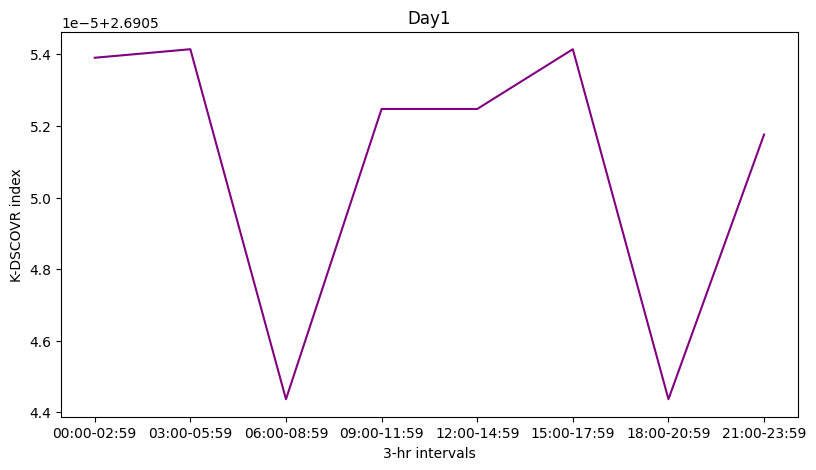

In [ ]:
fig=plt.figure()
fig.set_figwidth(9.5)
fig.set_figheight(5)
plt.title("Day1")
plt.xlabel("3-hr intervals")
plt.ylabel("K-DSCOVR index")
plt.plot(hours,day1,color="purple")

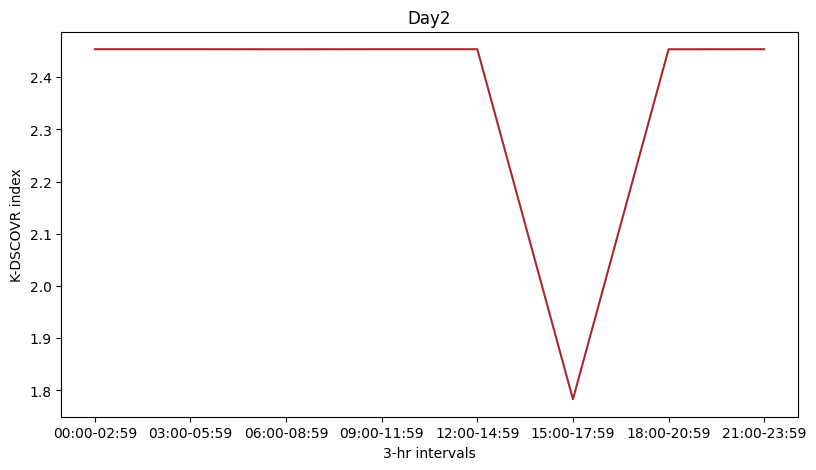

In [ ]:
fig=plt.figure()
fig.set_figwidth(9.5)
fig.set_figheight(5)
plt.title("Day2")
plt.xlabel("3-hr intervals")
plt.ylabel("K-DSCOVR index")
plt.plot(hours,day2,color="brown")

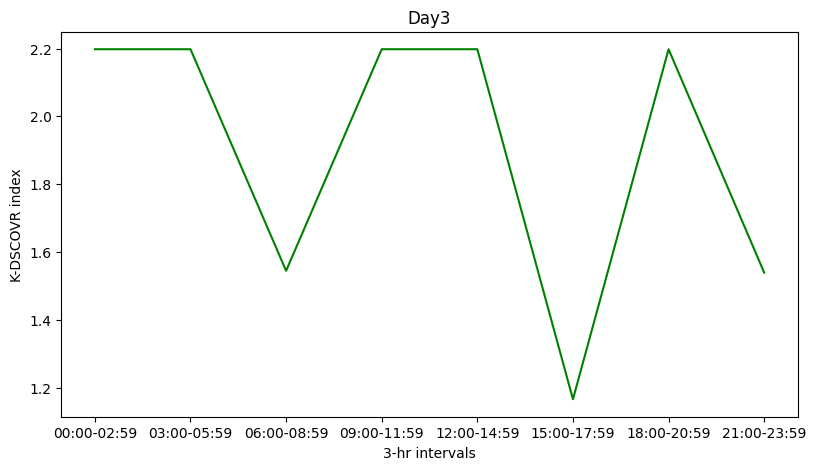

In [ ]:
fig=plt.figure()
fig.set_figwidth(9.5)
fig.set_figheight(5)
plt.title("Day3")
plt.xlabel("3-hr intervals")
plt.ylabel("K-DSCOVR index")
plt.plot(hours,day3,color="green")